## <center> LGBM

In [39]:
# %store -r X_train
# %store -r X_test

# %store -r y_train
# %store -r y_test

!pip install pandas --upgrade

In [ ]:
X_train =  pd.read_pickle("../input/X_train.pkl")
X_test =  pd.read_pickle("../input/X_test.pkl")
y_train =  pd.read_pickle("../input/y_train.pkl")
y_test =  pd.read_pickle("../input/y_test.pkl")

In [1]:
import numpy as np
import pandas as pd 

import warnings
import matplotlib.pyplot as plt
%matplotlib inline 

from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px

# Initialize plotly
init_notebook_mode(connected=True)

from IPython.core.debugger import set_trace
from time import time

from tqdm import tqdm
tqdm.pandas(desc="")
warnings.filterwarnings("ignore")
import os

# SKLEARN

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

# LightGBM
from lightgbm import LGBMRegressor
import lightgbm as lgb

# Sklearn-pandas
from sklearn_pandas import CategoricalImputer, FunctionTransformer, DataFrameMapper

# Bayessian Optimization
from bayes_opt import BayesianOptimization
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# vecstack
from vecstack import stacking

/Users/maksymsuprunenko/anaconda3/lib/python3.7/site-packages/tqdm/_tqdm.py:604: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [2]:
%%notify -m "Grid search LGBM was ended"
# params = {
#           'boosting_type': 'gbdt',
#           'objective': 'reg:squarederror',
#           'random_state': 1,
#           'max_bin': 512,
#           'subsample_for_bin': 200,
#           'subsample': 1,
#           'subsample_freq': 1,
#           'colsample_bytree': 0.8,
#           'reg_alpha': 5,
#           'reg_lambda': 10,
#           'min_split_gain': 0.5,
#           'min_child_weight': 1,
#           'min_child_samples': 5,
#           'metric' : 'rmse'
#          }

cat_feats = ['shop_id', 'key', 'item_category_id', 'item_id', 'date_block_num', 
             'item_category_names_category_1_enc', 'item_category_names_category_2_enc']

evals_result = {}

# Create parameters to search
gridParams = {
    'learning_rate': np.linspace(0.01, 2, 10),
    'max_depth': np.arange(0, 14),
    'n_estimators': np.arange(100, 1000, 100),
    'num_leaves': np.arange(8, 65, 8),
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : np.arange(0.5, 1.1, 0.1),
    'reg_alpha' : np.arange(0, 100),
    'reg_lambda' : np.arange(0, 100)
}

# Create classifier to use. Note that parameters have to be input manually
# not as a dict!
lgbm = LGBMRegressor(
           boosting_type= 'gbdt',
           objective = 'rmse',
           metric = "rmse",
          random_state= 1,
          silent = True)

# Create the grid
grid = RandomizedSearchCV(lgbm, gridParams, verbose=0, cv=TimeSeriesSplit(n_splits=5))
grid.fit(X_train, y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
#    evals_result=evals_result,
    verbose=10, 
    early_stopping_rounds=20,
    categorical_feature = cat_feats)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

# Using parameters already set above, replace in the best from the grid search
# params['colsample_bytree'] = grid.best_params_['colsample_bytree']
# params['learning_rate'] = grid.best_params_['learning_rate']
# params['max_bin'] = grid.best_params_['max_bin']
# params['num_leaves'] = grid.best_params_['num_leaves']
# params['reg_alpha'] = grid.best_params_['reg_alpha']
# params['reg_lambda'] = grid.best_params_['reg_lambda']
# params['subsample'] = grid.best_params_['subsample']
#params['subsample_for_bin'] = grid.best_params_['subsample_for_bin']

print('Fitting with params: ')
print(grid.best_params_)

TypeError: fit() got an unexpected keyword argument 'evals_result'

<IPython.core.display.Javascript object>

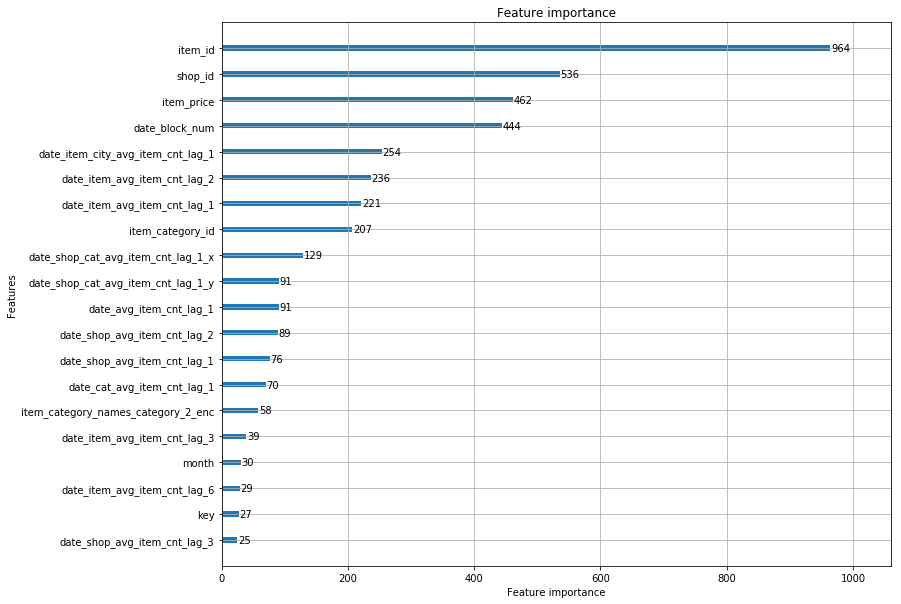

In [12]:
fig, ax = plt.subplots(figsize=(12,10))
ax = lgb.plot_importance(grid.best_estimator_, max_num_features=20, ax=ax)
plt.show()

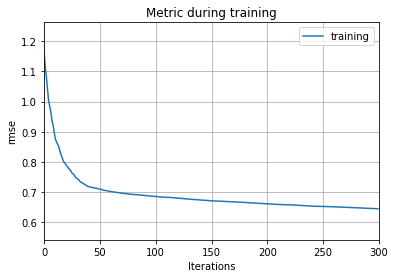

In [13]:
# ax = lgb.plot_metric(evals_result)
# plt.show()

In [ ]:
# def optimize_lgbm(n_classes, max_n_search=None):
#     # https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst
#     # https://indico.cern.ch/event/617754/contributions/2590694/attachments/1459648/2254154/catboost_for_CMS.pdf
#     space = {
#         #this is just piling on most of the possible parameter values for LGBM
#         #some of them apparently don't make sense together, but works for now.. :)
#         'class_weight': hp.choice('class_weight', [None, 'balanced']),
#         'boosting_type': hp.choice('boosting_type',
#                                    [{'boosting_type': 'gbdt',
# #                                     'subsample': hp.uniform('dart_subsample', 0.5, 1)
#                                      },
#                                     {'boosting_type': 'dart',
# #                                     'subsample': hp.uniform('dart_subsample', 0.5, 1)
#                                      },
#                                     {'boosting_type': 'goss'}]),
#         'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
#         'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
#         'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
#         'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
#         'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1), #alias "subsample"
#         'min_data_in_leaf': hp.qloguniform('min_data_in_leaf', 0, 6, 1),
#         'lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('lambda_l1_positive', -16, 2)]),
#         'lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('lambda_l2_positive', -16, 2)]),
#         'verbose': -1,
#         #the LGBM parameters docs list various aliases, and the LGBM implementation seems to complain about
#         #the following not being used due to other params, so trying to silence the complaints by setting to None
#         'subsample': None, #overridden by bagging_fraction
#         'reg_alpha': None, #overridden by lambda_l1
#         'reg_lambda': None, #overridden by lambda_l2
#         'min_sum_hessian_in_leaf': None, #overrides min_child_weight
#         'min_child_samples': None, #overridden by min_data_in_leaf
#         'colsample_bytree': None, #overridden by feature_fraction
# #        'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
#         'min_child_weight': hp.loguniform('min_child_weight', -16, 5), #also aliases to min_sum_hessian
# #        'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
# #        'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
# #        'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
#     }


#     global max_n
#     max_n = max_n_search
#     trials = Trials()
#     best = fmin(fn=objective_sklearn,
#                 space=space,
#                 algo=tpe.suggest,
#                 max_evals=n_trials,
#                 trials=trials,
#                verbose= 1)

#     # find the trial with lowest loss value. this is what we consider the best one
#     idx = np.argmin(trials.losses())
#     print(idx)

#     print(trials.trials[idx])

#     # these should be the training parameters to use to achieve the best score in best trial
#     params = trials.trials[idx]["result"]["params"]
#     max_n = None

#     print(params)
#     return params

In [18]:
# import pandas as pd
# import numpy as np

# result = lgbm.predict(X_test)

# submission = pd.DataFrame({
#     "ID": np.arange(result.shape[0]), 
#     "item_cnt_month": result
# })

# submission.to_csv('lgbm_submission.csv', index=False)